# Analysis of EMBARC Flanker Data

In [158]:
import datetime, mmap,os,re, sys, decimal, hddm
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import pearsonr,shapiro,sem,ttest_ind
from patsy import dmatrix
import warnings 
warnings.filterwarnings('ignore')# I'm sick of all the red.
os.environ['R_HOME'] = '/Users/mlm2/anaconda/envs/pythonthreefive/lib/R' # couldn't find R in this environment for some reason
% matplotlib inline 
% load_ext rpy2.ipython
%R library(lsmeans)
%R library(afex)
%R library(ppcor)
%cd /Users/mlm2/Work/Expts/EMBARC/
import Flanker_proc

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
/Users/mlm2/Work/Expts/EMBARC


## Getting Data Together

In [20]:
uname = !whoami
uname = uname[0]
path2analysis = '/Users/' + uname + '/Work/Expts/EMBARC/' # also where git repo lives
today = datetime.datetime.today().strftime("%m_%d_%Y")

In [21]:
# getting in the clinical data that tells us which group the participant is in

clin_data = pd.read_csv(path2analysis + 'Data/groups.csv', encoding="latin-1")
clin_data = clin_data[['ProjectSpecificID', 'feasibility', 'shaps_total_dichotomous', 
                       'shaps_total_continuous', 'severity1','partic_age', 'partic_gender', 
                       'masq2_29', 'hamd_09']] 
clin_data = clin_data[pd.notnull(clin_data['feasibility'])] # only care where there is a val for feasibility
clin_data.head()

,ProjectSpecificID,feasibility,shaps_total_dichotomous,shaps_total_continuous,severity1,partic_age,partic_gender,masq2_29,hamd_09
1,TX0001,2.0,0.0,15.0,1.0,58.0,Female,5.0,0.0
3,TX0005,2.0,6.0,34.0,0.0,42.0,Female,4.0,0.0
5,TX0006,2.0,9.0,40.0,1.0,52.0,Female,5.0,0.0
7,TX0007,2.0,0.0,16.0,2.0,20.0,Female,1.0,0.0
9,TX0008,2.0,4.0,31.0,2.0,28.0,Male,3.0,0.0


In [22]:
clin_data.tail()

,ProjectSpecificID,feasibility,shaps_total_dichotomous,shaps_total_continuous,severity1,partic_age,partic_gender,masq2_29,hamd_09
707,CU0132,1.0,9.0,38.0,0.0,24.0,Female,5.0,0.0
709,CU0133,1.0,5.0,32.0,1.0,24.0,Female,4.0,0.0
711,CU0134,1.0,0.0,16.0,0.0,64.0,Female,5.0,0.0
713,CU0135,1.0,7.0,36.0,1.0,23.0,Female,5.0,0.0
715,CU0071,5.0,2.0,24.0,0.0,18.0,Female,5.0,0.0


In [4]:
## Preventive maintenance: clean up files with problems before starting the processing

## Rename file for Michigan subject 79, session 2 (subject and session were swapped)

!mv /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-2-0079.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-0079-2.txt

# Now correct the Subject and Session information for Michigan subject 79, session 2

!sed -e 's/Subject: 2/Subject: 79/' -e 's/Session: 0079/Session: 2/' \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-0079-2.txt > \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/temp.txt

!mv /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/temp.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-0079-2.txt

## Correct the subject number for Texas subject 61 (subject was entered as 695, session as 61)

!sed -e 's/Subject: 695/Subject: 0061/' -e 's/Session: 0061/Session: 1/' < \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_01172012-0061-1.txt > \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/temp.txt

!mv /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/temp.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_01172012-0061-1.txt

## Remove file labeled '038' for Texas; they are binary files, and there are already fine '0038' files

!rm /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_01172012-038-1.txt

## Correct the Subject and Session information for Texas subject 6, session 1 (they were reversed).
## File also ends with *1txt.txt, so overwrite it with a file ending *1.txt.

!sed -e 's/Subject: 1/Subject: 0006/' -e 's/Session: 0006/Session: 1/' < \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_04292011-0006-1.txt.txt > \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/temp.txt

!rm /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_04292011-0006-1.txt.txt

!mv /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/temp.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles/Flanker_EMBARC_04292011-0006-1.txt

## Correct the Subject information for Michigan subject 37, session 1. It is correct in the filename and in one
## line of the file, but is '0028' on another line, which will cause the processed data to be labeled as 0028.
## Since there are multiple other files for Michigan subject 37 and no others for Michigan subject 28, I am sticking
## with 37 as the correct subject number.

!sed -e 's/Subject: 0028/Subject: 0037/' < \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-0037-1.txt > \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/temp.txt

!mv /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/temp.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Michigan/EprimeOutFiles/Flanker_EMBARC_121312-0037-1.txt

## Replace files that were accidentally overwritten when traveling controls were processed. These are files for:
# MG subject 26, session 1
# NY subject 18, session 1
# NY subject 19, session 1
# TX subject 33, session 1

!cp /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0018-1.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/New_York/EprimeOutFiles

!cp /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0019-1.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/New_York/EprimeOutFiles

!cp /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0026-1.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Massachusetts/EprimeOutFiles

!cp /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0033-1.txt \
/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Texas/EprimeOutFiles

cp: /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0018-1.txt: No such file or directory
cp: /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0019-1.txt: No such file or directory
cp: /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0026-1.txt: No such file or directory
cp: /Users/mlm2/Work/Expts/EMBARC/Data/Misc/Overwritten_by_TCs/Flanker_EMBARC_01172012-0033-1.txt: No such file or directory


In [5]:
%cd /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/

# Regex definitions

site_d = re.compile('Site:\s([A-Za-z]+\s*[A-Za-z]+)')
sub_d = re.compile('Subject:\s(\d+)')
sess_d = re.compile('Session:\s([12])') # Excluding any session 3 data as that should always correspond to traveling ctrl

# Work on files from each site separately, as the filenames may overlap

sites = ['Massachusetts','Michigan','New_York','Texas']

for site in sites:
    # Grab files, omitting practice and 'output' files, as well as any labeled as session 3 (i.e., traveling ctrls)
    # Also omit CU0004 files labeled 'org', which were from an aborted, 'original' run that was re-run 
    file_list = !ls $site/EprimeOutFiles/*txt | grep 'Flanker_EMBARC_[0-9]' | grep -v '3.txt$' | grep -v 'org'
    
    for current_file in file_list:
               
        site = 'NA'
        sub = np.nan
        sess = np.nan
        
        with open(current_file,'r', encoding="latin-1") as f:
        
            for line in f:
                
                site_m = site_d.search(line)
                sub_m = sub_d.search(line)
                sess_m = sess_d.search(line)
                
                # Site
                if site_m:
                    site = site_m.group(1)
                    
                    if site == 'Massachusetts':
                        site = 'MG'
                    
                    elif site == 'Michigan':
                        site = 'UM'
                    
                    elif site == 'New York':
                        site = 'CU'
                    
                    elif site == 'Texas':
                        site = 'TX'
                             
                # Subject
                if sub_m:
                    subject = sub_m.group(1)
                    subject = subject.zfill(4) # Subject should always be width=4
        
                # Session
                if sess_m:
                    session = sess_m.group(1)
                    
        fname = site + '_' + subject + '_' + str(session) + '.txt'           
        !cp $current_file /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Raw/$fname 

/Users/mlm2/Work/Expts/EMBARC/Data/Flanker


In [9]:
## Push raw data through processing stream in order to get (a) CSV files that could be used
## for DDM analysis and (b) summary files with interference, gratton, and rab/lam effects

%cd /Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Raw/

# Iterate over files, extracting site, subject, and session information from filenames
# Place single-subject trial-level and summary into 'ddm_pieces' and 'sum_pieces', respectively
# Write out single-subject trial-level CSV and group summary CSV for safe-keeping

ddm_pieces = []
sum_pieces = []

file_list = !ls *txt

for current_file in file_list:
    
    site = current_file.split('_')[0]
    sub = current_file.split('_')[1]
    sess = current_file.split('_')[2]
    sess = sess.split('.')[0]
    #print(sub)
    
    fname = site + '_' + sub + '_' + sess + '.csv'
                        
    # Output clean CSV for the DDM, also append it to 'ddm_pieces'
    clean_df = Flanker_proc.clean(current_file)
    clean_df['site'] = site
    clean_df = clean_df[['site','subject','session','block','trial','stimulus','response','accuracy','rt','feedback',
                         'ln_rt','outlier','rab_lam','gratton']]
    try:
        clean_df.to_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/' + fname, index=False)
    except:
        print ('didnt work')
    ddm_pieces.append(clean_df)
    
    # Generate the summary and place it in 'sum_pieces'
    
    sum_frame = Flanker_proc.summarize(clean_df)
    sum_frame['site'] = site
    sum_frame['subject'] = sub
    sum_frame['session'] = sess
    
    sum_pieces.append(sum_frame)
 
# Concatenate pieces into dfs

trial_summary = pd.concat(ddm_pieces)
trial_summary.sort(['site','subject','session'],inplace=True)
trial_summary

flanker_summary = pd.concat(sum_pieces)   
flanker_summary.sort(columns=['site','subject','session'],inplace=True)

# For the Flanker Summary, create and add ProjectSpecificID for merge with PA clin file.

new_subject = []

flanker_summary['subject'] = flanker_summary['subject'].astype(str)

for i, row_i in flanker_summary.iterrows():
    new_subject.append(row_i['subject'].zfill(4))

flanker_summary['subject'] = new_subject
flanker_summary['ProjectSpecificID'] = flanker_summary['site'] + flanker_summary['subject']

# Put the summary columns in a nicer order

# flanker_summary = flanker_summary[['ProjectSpecificID', 'site', 'subject', 'session','num_outs', 'num_noresp', 
#                                    'num_con_trls', 'con_acc', 'con_corr_rt', 'num_inc_trls', 'inc_acc', 'inc_corr_rt', 
#                                    'num_post_inc_err', 'flanker_qc', 'gratton_qc', 'rab_lam_qc', 'flanker_acc', 
#                                    'flanker_rt', 'gratton_acc', 'gratton_rt', 'rab_lam_acc', 'rab_lam_rt']]

flanker_summary = flanker_summary[['ProjectSpecificID', 'site', 'subject', 'session', 'num_outs', 'num_noresp', 
                                   'num_con_trls', 'con_acc', 'con_corr_rt', 'num_inc_trls', 'inc_acc', 
                                   'inc_corr_rt', 'con_inc_acc', 'con_inc_rt', 'inc_inc_acc', 'inc_inc_rt', 
                                   'post_err_acc', 'post_err_rt', 'post_corr_acc', 'post_corr_rt', 
                                   'num_post_inc_err', 'flanker_qc', 'gratton_qc', 'rab_lam_qc', 'flanker_acc', 
                                   'flanker_rt', 'gratton_acc', 'gratton_rt', 'rab_lam_acc', 'rab_lam_rt']]

# Write trial-level data and group summary to CSV

trial_summary.to_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_DDM_'
                     + datetime.datetime.now().strftime('%b-%d-%I%M%p-%G') + '.csv',index=False)

flanker_summary.to_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_Summary_' 
                       + datetime.datetime.now().strftime('%b-%d-%I%M%p-%G') + '.csv',index=False)


/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Raw


In [10]:
len(flanker_summary)

719

In [11]:
flanker_summary.head()

,ProjectSpecificID,site,subject,session,num_outs,num_noresp,num_con_trls,con_acc,con_corr_rt,num_inc_trls,...,num_post_inc_err,flanker_qc,gratton_qc,rab_lam_qc,flanker_acc,flanker_rt,gratton_acc,gratton_rt,rab_lam_acc,rab_lam_rt
0,CU0001,CU,0001,1,4,4,224,0.995536,407.587444,118,...,5,1,1,0,0.046383,44.707199,-0.009868,10.944079,0.018018,13.025225
0,CU0001,CU,0001,2,3,0,230,0.991304,376.175439,117,...,2,1,1,0,0.008398,36.581083,-0.048514,11.536082,0.008772,-12.403509
0,CU0002,CU,0002,1,3,3,228,0.986842,417.062222,116,...,8,1,1,1,0.055808,93.900741,-0.004758,-40.540048,0.028302,79.365566
0,CU0002,CU,0002,2,2,0,229,0.995633,385.885965,119,...,13,1,1,1,0.104877,85.661205,0.120000,-19.885000,0.000000,7.757509
0,CU0003,CU,0003,1,2,23,214,0.953271,326.240196,111,...,41,1,1,1,0.331649,74.817775,0.027299,-11.556034,0.020579,6.974085


In [12]:
flanker_summary.tail()

,ProjectSpecificID,site,subject,session,num_outs,num_noresp,num_con_trls,con_acc,con_corr_rt,num_inc_trls,...,num_post_inc_err,flanker_qc,gratton_qc,rab_lam_qc,flanker_acc,flanker_rt,gratton_acc,gratton_rt,rab_lam_acc,rab_lam_rt
0,UM0119,UM,0119,2,7,0,227,0.995595,339.743363,116,...,6,1,1,1,0.047319,74.020274,0.063830,-8.336879,0.000000,28.870370
0,UM0120,UM,0120,1,2,0,228,1.000000,280.864035,120,...,22,1,1,1,0.191667,44.074109,0.000619,-3.655322,-0.014527,-3.774133
0,UM0120,UM,0120,2,0,0,230,0.995652,265.074236,120,...,25,1,1,1,0.203986,44.715238,0.017822,9.993399,0.031579,4.023158
0,UM0121,UM,0121,1,3,1,227,1.000000,427.563877,119,...,12,1,1,1,0.100840,116.333320,0.112245,-32.688383,0.000000,-11.724359
0,UM0121,UM,0121,2,6,0,227,0.995595,419.867257,117,...,6,1,1,1,0.055424,84.514562,-0.007277,6.311704,0.018349,-3.174312


In [13]:
len(trial_summary)

251528

In [14]:
trial_summary.head()

,site,subject,session,block,trial,stimulus,response,accuracy,rt,feedback,ln_rt,outlier,rab_lam,gratton
0,CU,1,1,1,1,INC,right,1.0,697.0,TOO_SLOW,6.546785,0,0,0
1,CU,1,1,1,2,CON,left,1.0,402.0,Blank,5.996452,0,2,0
2,CU,1,1,1,3,INC,left,1.0,390.0,Blank,5.966147,0,0,1
3,CU,1,1,1,4,CON,right,1.0,342.0,Blank,5.834811,0,2,0
4,CU,1,1,1,5,INC,left,1.0,406.0,Blank,6.006353,0,0,1


In [15]:
trial_summary.tail()

,site,subject,session,block,trial,stimulus,response,accuracy,rt,feedback,ln_rt,outlier,rab_lam,gratton
345,UM,121,2,5,66,INC,left,1.0,529.0,Blank,6.270988,0,0,1
346,UM,121,2,5,67,INC,right,1.0,547.0,Blank,6.304449,0,2,2
347,UM,121,2,5,68,CON,right,1.0,429.0,Blank,6.061457,0,2,0
348,UM,121,2,5,69,CON,right,1.0,355.0,Blank,5.872118,0,0,0
349,UM,121,2,5,70,CON,left,1.0,453.0,Blank,6.115892,0,0,0


In [31]:
flk_sum = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_Summary_Mar-01-0144PM-2017.csv')
flk_ddm = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_DDM_Mar-01-0144PM-2017.csv')
clin_data = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_Clin_s1_Mar-01-0150PM-2017.csv')

In [32]:
# Merge the session 1 flanker summary with the clinical data and write out
s1 = flk_sum[(flk_sum['session'] == 1)]
flk_clin_s1 = pd.merge(s1,clin_data,on='ProjectSpecificID')
flk_clin_s1.to_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_Clin_s1_'
                     + datetime.datetime.now().strftime('%b-%d-%I%M%p-%G') + '.csv',index=False)

In [37]:
# Add group data to the flk_ddm dataframe by merging it with the clinical data, 
# then select session 1 data for controls and MDD before sending to TW.

# Add ProjectSpecificID to flk_ddm
new_subs = []
flk_ddm['subject'] = flk_ddm['subject'].astype(int)
flk_ddm['subject'] = flk_ddm['subject'].astype(str)

for i, row_i in flk_ddm.iterrows():
    sub = row_i['subject'].zfill(4)
    new_subs.append(sub)

flk_ddm['subject'] = new_subs
flk_ddm['ProjectSpecificID'] = flk_ddm['site']+ flk_ddm['subject']

# Match on ProjectSpecificID with clin_data
flk_ddm_clin = pd.merge(flk_ddm,clin_data,on='ProjectSpecificID')

# Select only control (feasibility = 4.0) and MDD (feasibility = 3.0) subjects
flk_ddm_clin = flk_ddm_clin[(flk_ddm_clin.feasibility != 2.0)]
flk_ddm_clin.rename(columns={'site_x': 'site', 'subject_x': 'subject', 'session_x': 'session'}, inplace=True)
# Group: 0 = controls, 1 = MDD
flk_ddm_clin['group'] = flk_ddm_clin['feasibility']
flk_ddm_clin['group'].replace(to_replace = 1.0,value = 'MDD', inplace = True) #MDD = 1
flk_ddm_clin['group'].replace(to_replace = 3.0,value = 'MDD', inplace = True) #MDD = 1
flk_ddm_clin['group'].replace(to_replace = 5.0,value = 'MDD', inplace = True) #MDD = 1
flk_ddm_clin['group'].replace(to_replace = 4.0,value = 'CTL', inplace = True) #Ctrl = 0

# Now select session 1 data to send to TW
flk_ddm_clin_s1 = flk_ddm_clin[flk_ddm_clin['session'] == 1]

# Now just write out ProjectSpecific ID, group, and all the flanker columns. I am not writing out everything b/c with
# the clinical data repeated on every single line, the file that would be written out would be huge (~200MB).

flk_ddm_clin_s1 = flk_ddm_clin_s1[['ProjectSpecificID','site','subject','session','group','block','trial','stimulus',
                             'response','accuracy','rt','feedback','ln_rt','outlier','rab_lam','gratton']]

# Use lines below to confirm number of subjects in each group. As of June 17, 2014, there are 40 ctrls and 98 mdd.
bygroup = flk_ddm_clin_s1.groupby('group')
bygroup['ProjectSpecificID'].nunique()

# Write out the file for TW
flk_ddm_clin_s1.to_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_DDM_Clin_s1_'
                     + datetime.datetime.now().strftime('%b-%d-%I%M%p-%G') + '.csv',index=False)

## Analysis

In [51]:
# Working with 'flk_clin_s1' as the bash-like summary file merged with the latest PA spreadsheet
# First select the controls (feasibility = 4) and the mdds (feasibility = 3), add 'group' col, and re-label groups
flk_clin_s1 = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_Clin_s1_Mar-01-0150PM-2017.csv')
flk_clin_s1 = flk_clin_s1[(flk_clin_s1.feasibility != 2.0)]
flk_clin_s1['group'] = flk_clin_s1['feasibility']
flk_clin_s1['group'].replace(to_replace = 1.0,value = 'MDD', inplace = True) #MDD = 1
flk_clin_s1['group'].replace(to_replace = 3.0,value = 'MDD', inplace = True) #MDD = 1
flk_clin_s1['group'].replace(to_replace = 5.0,value = 'MDD', inplace = True) #MDD = 1
flk_clin_s1['group'].replace(to_replace = 4.0,value = 'CTL', inplace = True) #Ctrl = 0

In [62]:
flk_clin_s1.tail()

,ProjectSpecificID,site,subject,session,num_outs,num_noresp,num_con_trls,con_acc,con_corr_rt,num_inc_trls,...,rab_lam_rt,feasibility,shaps_total_dichotomous,shaps_total_continuous,severity1,partic_age,partic_gender,masq2_29,hamd_09,group
347,UM0117,UM,117,1,2,0,228,0.991228,334.557522,120,...,34.410487,1.0,0.0,28.0,0.0,45.0,Male,3.0,0.0,MDD
348,UM0118,UM,118,1,2,1,228,0.986842,340.906667,119,...,-1.619048,1.0,3.0,32.0,0.0,19.0,Female,5.0,2.0,MDD
349,UM0119,UM,119,1,9,1,224,1.000000,336.991071,116,...,-7.355346,1.0,2.0,29.0,0.0,32.0,Male,5.0,0.0,MDD
350,UM0120,UM,120,1,2,0,228,1.000000,280.864035,120,...,-3.774133,1.0,0.0,26.0,0.0,20.0,Female,4.0,0.0,MDD
351,UM0121,UM,121,1,3,1,227,1.000000,427.563877,119,...,-11.724359,1.0,8.0,36.0,0.0,56.0,Female,5.0,0.0,MDD


In [59]:
flk_clin_s1.groupby(['site', 'group'])['ProjectSpecificID'].nunique()

site  group
CU    CTL       9
      MDD      86
MG    CTL      10
      MDD      52
TX    CTL       9
      MDD      97
UM    CTL      10
      MDD      57
Name: ProjectSpecificID, dtype: int64

In [65]:
flk_clin_s1.groupby(['group'])['ProjectSpecificID'].nunique()

group
CTL     38
MDD    292
Name: ProjectSpecificID, dtype: int64

In [67]:
# Compare these with the PRT people. Need to look into each one and see why they weren't included
df_christian = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/christian_included.txt', header = None)    
christian_list = df_christian[0].astype(str)

# are we missing anything?
for subject in christian_list:
    if subject in flk_clin_s1.ProjectSpecificID.unique():
        pass
    else:
        print('Missing from ours: '+ subject)

# do we have anything extra?
for subject in flk_clin_s1.ProjectSpecificID:
    if subject in christian_list.unique():
        pass
    else:
        print('Not included in Christians: ' + subject)

Missing from ours: TX0165
Missing from ours: CU0018
Missing from ours: TX0033
Not included in Christians: CU0019
Not included in Christians: CU0021
Not included in Christians: CU0060
Not included in Christians: CU0062
Not included in Christians: CU0064
Not included in Christians: CU0113
Not included in Christians: CU0125
Not included in Christians: CU0126
Not included in Christians: CU0133
Not included in Christians: MG0008
Not included in Christians: MG0021
Not included in Christians: MG0026
Not included in Christians: MG0116
Not included in Christians: MG0182
Not included in Christians: MG0185
Not included in Christians: MG0238
Not included in Christians: MG0242
Not included in Christians: MG0246
Not included in Christians: MG0257
Not included in Christians: TX0011
Not included in Christians: TX0016
Not included in Christians: TX0020
Not included in Christians: TX0050
Not included in Christians: TX0060
Not included in Christians: TX0066
Not included in Christians: TX0097
Not included

In [66]:
# Now select only those subjects who pass the Flanker QC check at session 1
flk_use = flk_clin_s1[flk_clin_s1.flanker_qc == 1]
bygroup = flk_use.groupby('group')
bygroup.ProjectSpecificID.nunique()

group
CTL     35
MDD    266
Name: ProjectSpecificID, dtype: int64

In [69]:
# Which subjects get excluded based on flanker QC fails?
flk_qc_fails = []

flk_ids = flk_clin_s1.ProjectSpecificID.unique()
flk_ids = flk_ids.tolist()

flk_use_ids = flk_use.ProjectSpecificID.unique()
flk_use_ids = flk_use_ids.tolist()

for sub in flk_ids:
    if sub not in flk_use_ids:
        print (sub + ' was excluded based on flanker QC fail')
        flk_qc_fails.append(sub)

CU0017 was excluded based on flanker QC fail
CU0025 was excluded based on flanker QC fail
CU0060 was excluded based on flanker QC fail
CU0062 was excluded based on flanker QC fail
CU0110 was excluded based on flanker QC fail
CU0116 was excluded based on flanker QC fail
MG0007 was excluded based on flanker QC fail
MG0116 was excluded based on flanker QC fail
MG0125 was excluded based on flanker QC fail
MG0182 was excluded based on flanker QC fail
MG0206 was excluded based on flanker QC fail
MG0209 was excluded based on flanker QC fail
MG0238 was excluded based on flanker QC fail
MG0251 was excluded based on flanker QC fail
TX0037 was excluded based on flanker QC fail
TX0050 was excluded based on flanker QC fail
TX0062 was excluded based on flanker QC fail
TX0068 was excluded based on flanker QC fail
TX0101 was excluded based on flanker QC fail
TX0124 was excluded based on flanker QC fail
TX0139 was excluded based on flanker QC fail
TX0147 was excluded based on flanker QC fail
TX0188 was

## Descriptive data and group comparisons on demographics, Flanker interference, Gratton, and Rabbit/Laming effects

In [73]:
%Rpush flk_use

**Age**  
No group difference

In [84]:
bygroup['partic_age'].describe()

group       
CTL    count     35.000000
       mean      36.400000
       std       14.637181
       min       18.000000
       25%       25.000000
       50%       31.000000
       75%       52.000000
       max       62.000000
MDD    count    266.000000
       mean      37.056391
       std       13.011483
       min       18.000000
       25%       26.000000
       50%       34.000000
       75%       47.000000
       max       65.000000
Name: partic_age, dtype: float64

In [82]:
%R print(t.test(partic_age ~ group,flk_use))


	Welch Two Sample t-test

data:  partic_age by group
t = -0.2525, df = 41.38, p-value = 0.8019
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -5.904880  4.592098
sample estimates:
mean in group CTL mean in group MDD 
         36.40000          37.05639 



**Gender**  
No group difference

In [87]:
print (bygroup['partic_gender'].value_counts())

group  partic_gender
CTL    Female            21
       Male              14
MDD    Female           174
       Male              92
Name: partic_gender, dtype: int64


In [89]:
obs = np.array([[21,14],[174,92]])
chi2, p, dof, expected = sp.stats.chi2_contingency(obs,correction=False)
print ("Chi-square on Gender: chi-square = " + "{:.2f}".format(chi2) + "; df = " + "{:.2f}".format(dof) + \
"; p = " + "{:.2f}".format(p))

Chi-square on Gender: chi-square = 0.40; df = 1.00; p = 0.53


### Flanker interference 

In [91]:
# No group difference in accuracy
bygroup['flanker_acc'].describe()

group       
CTL    count     35.000000
       mean       0.215206
       std        0.124715
       min        0.033898
       25%        0.109499
       50%        0.191667
       75%        0.291150
       max        0.491667
MDD    count    266.000000
       mean       0.192571
       std        0.112452
       min       -0.004425
       25%        0.113902
       50%        0.181920
       75%        0.249781
       max        0.473576
Name: flanker_acc, dtype: float64

In [92]:
# Accuracy on CON trials is very similar across groups
bygroup['con_acc'].describe()

group       
CTL    count     35.000000
       mean       0.987746
       std        0.012436
       min        0.964126
       25%        0.977974
       50%        0.991228
       75%        1.000000
       max        1.000000
MDD    count    266.000000
       mean       0.984663
       std        0.026325
       min        0.715596
       25%        0.981879
       50%        0.991266
       75%        1.000000
       max        1.000000
Name: con_acc, dtype: float64

In [94]:
# INC accuracy is slightly higher in MDDs
bygroup['inc_acc'].describe()

group       
CTL    count     35.000000
       mean       0.772539
       std        0.127243
       min        0.508333
       25%        0.702836
       50%        0.788136
       75%        0.885122
       max        0.966102
MDD    count    266.000000
       mean       0.792092
       std        0.116430
       min        0.504202
       25%        0.726523
       50%        0.805904
       75%        0.872881
       max        1.000000
Name: inc_acc, dtype: float64

In [95]:
# Looking for group difference in RT
bygroup['flanker_rt'].describe()

group       
CTL    count     35.000000
       mean      86.775766
       std       21.246150
       min       55.906337
       25%       72.455585
       50%       84.915119
       75%       95.206870
       max      159.605979
MDD    count    266.000000
       mean      92.410056
       std       21.752345
       min       37.341151
       25%       79.214792
       50%       93.169638
       75%      105.274141
       max      169.608911
Name: flanker_rt, dtype: float64

In [96]:
# Controls are faster than MDDs with respect to correct CON RT
bygroup['con_corr_rt'].describe()

group       
CTL    count     35.000000
       mean     359.971081
       std       43.773767
       min      294.875556
       25%      328.433881
       50%      356.632743
       75%      388.156132
       max      499.517544
MDD    count    266.000000
       mean     377.597464
       std       52.555303
       min      271.885463
       25%      340.290000
       50%      368.076038
       75%      406.799559
       max      574.513761
Name: con_corr_rt, dtype: float64

In [97]:
# Controls are also faster than depressed with respect to INC correct RT
bygroup['inc_corr_rt'].describe()

group       
CTL    count     35.000000
       mean     446.746847
       std       46.097367
       min      378.672131
       25%      410.016758
       50%      443.597938
       75%      464.131616
       max      574.802326
MDD    count    266.000000
       mean     470.007520
       std       57.848143
       min      324.938144
       25%      429.519792
       50%      462.475121
       75%      504.617527
       max      712.000000
Name: inc_corr_rt, dtype: float64

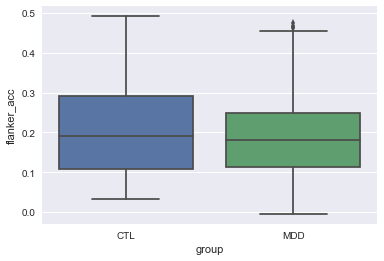

In [100]:
# boxplot showing interference effect on accuracy by group
sns.boxplot(flk_use['flanker_acc'],groupby=flk_use['group'],names=['Control','MDD'])

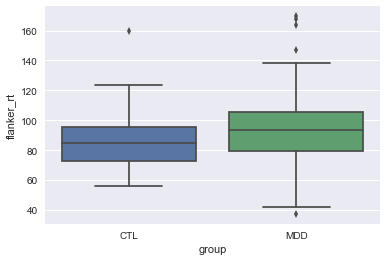

In [101]:
# boxplot showing interference effect on RT by group
sns.boxplot(flk_use['flanker_rt'],groupby=flk_use['group'],names=['Control','MDD'])

In [102]:
# How about number of outliers per group? Slightly higher in MDD, but not much of a difference.
bygroup.num_outs.describe()

group       
CTL    count     35.000000
       mean       3.342857
       std        1.570741
       min        0.000000
       25%        2.000000
       50%        3.000000
       75%        4.000000
       max        7.000000
MDD    count    266.000000
       mean       3.545113
       std        2.221642
       min        0.000000
       25%        2.000000
       50%        3.000000
       75%        5.000000
       max       18.000000
Name: num_outs, dtype: float64

In [104]:
# For interference effect on accuracy, confirm that effect is greater than zero in each group, and then check group diff.
%R flk_use.ctrl <- subset(flk_use,group == 'CTL')
%R flk_use.mdd <- subset(flk_use,group == 'MDD')
%R print(t.test(flk_use.ctrl$flanker_acc,mu=0)) # Controls, p < 0.001
%R print(t.test(flk_use.mdd$flanker_acc,mu=0)) # MDD, p < 0.001
%R print(t.test(flanker_acc ~ group,flk_use)) # ****The trend found with the first half of the data is gone here*****


	One Sample t-test

data:  flk_use.ctrl$flanker_acc
t = 10.209, df = 34, p-value = 6.855e-12
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.1723654 0.2580473
sample estimates:
mean of x 
0.2152064 




	One Sample t-test

data:  flk_use.mdd$flanker_acc
t = 27.93, df = 265, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.1789954 0.2061468
sample estimates:
mean of x 
0.1925711 




	Welch Two Sample t-test

data:  flanker_acc by group
t = 1.0205, df = 41.602, p-value = 0.3134
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.02213750  0.06740807
sample estimates:
mean in group CTL mean in group MDD 
        0.2152064         0.1925711 



In [105]:
# For interference effect on RT, confirm that effect is greater than zero in each group, and then check group diff.
%R print(t.test(flk_use.ctrl$flanker_rt,mu=0)) # Controls, p < 0.001
%R print(t.test(flk_use.mdd$flanker_rt,mu=0)) # MDD, p < 0.001
%R print(t.test(flanker_rt ~ group,flk_use)) #  p = 0.149


	One Sample t-test

data:  flk_use.ctrl$flanker_rt
t = 24.163, df = 34, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 79.47746 94.07407
sample estimates:
mean of x 
 86.77577 




	One Sample t-test

data:  flk_use.mdd$flanker_rt
t = 69.287, df = 265, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 89.78402 95.03610
sample estimates:
mean of x 
 92.41006 




	Welch Two Sample t-test

data:  flanker_rt by group
t = -1.4707, df = 43.918, p-value = 0.1485
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -13.355402   2.086821
sample estimates:
mean in group CTL mean in group MDD 
         86.77577          92.41006 



In [106]:
# Gratton effect on accuracy--looks the same
bygroup.gratton_acc.describe()

group       
CTL    count     35.000000
       mean       0.069278
       std        0.098367
       min       -0.111111
       25%        0.003882
       50%        0.054545
       75%        0.136324
       max        0.274561
MDD    count    266.000000
       mean       0.069786
       std        0.114277
       min       -0.328462
       25%        0.001052
       50%        0.069954
       75%        0.138947
       max        0.435354
Name: gratton_acc, dtype: float64

In [107]:
# Gratton effect on RT--negative is better, and it looks more negative in controls
bygroup.gratton_rt.describe()

group       
CTL    count     35.000000
       mean      -8.003311
       std       21.848722
       min      -65.165789
       25%      -18.141826
       50%       -4.196285
       75%        5.739958
       max       22.560606
MDD    count    266.000000
       mean      -2.910442
       std       21.578954
       min      -60.111111
       25%      -18.144889
       50%       -2.238752
       75%       10.784784
       max       73.210870
Name: gratton_rt, dtype: float64

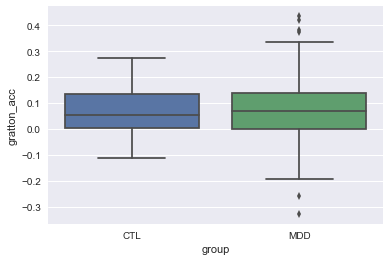

In [108]:
# Gratton accuracy effect
sns.boxplot(flk_use.gratton_acc,groupby=flk_use.group,names=['Control','MDD'])

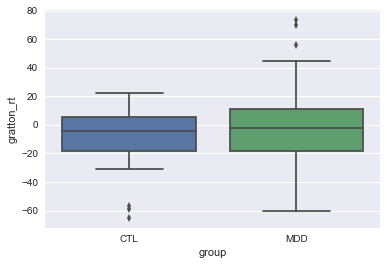

In [109]:
# Gratton RT effect
sns.boxplot(flk_use.gratton_rt,groupby=flk_use.group,names=['Control','MDD'])

In [110]:
# For Gratton effect on accuracy, see if effect is greater than zero in each group, and then check group diff.
%R print(t.test(flk_use.ctrl$gratton_acc,mu=0)) # Controls, p < .001
%R print(t.test(flk_use.mdd$gratton_acc,mu=0)) # MDD, p < .001
%R print(t.test(gratton_acc ~ group,flk_use)) # No group difference, p = 0.98


	One Sample t-test

data:  flk_use.ctrl$gratton_acc
t = 4.1666, df = 34, p-value = 0.0002004
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.03548761 0.10306813
sample estimates:
 mean of x 
0.06927787 




	One Sample t-test

data:  flk_use.mdd$gratton_acc
t = 9.9598, df = 265, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.05599023 0.08358227
sample estimates:
 mean of x 
0.06978625 




	Welch Two Sample t-test

data:  gratton_acc by group
t = -0.028176, df = 46.958, p-value = 0.9776
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.03680731  0.03579054
sample estimates:
mean in group CTL mean in group MDD 
       0.06927787        0.06978625 



In [111]:
# For Gratton effect on RT, see if effect is less than zero in each group, and then check group diff.
%R print(t.test(flk_use.ctrl$gratton_rt,mu=0)) # Controls, p = .03
%R print(t.test(flk_use.mdd$gratton_rt,mu=0)) # MDD, p = .029
%R print(t.test(gratton_rt ~ group,flk_use)) # No group difference, p = 0.20


	One Sample t-test

data:  flk_use.ctrl$gratton_rt
t = -2.1671, df = 34, p-value = 0.03732
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -15.5086102  -0.4980127
sample estimates:
mean of x 
-8.003311 




	One Sample t-test

data:  flk_use.mdd$gratton_rt
t = -2.1997, df = 265, p-value = 0.02869
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -5.5155497 -0.3053347
sample estimates:
mean of x 
-2.910442 




	Welch Two Sample t-test

data:  gratton_rt by group
t = -1.2982, df = 43.197, p-value = 0.2011
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -13.003231   2.817493
sample estimates:
mean in group CTL mean in group MDD 
        -8.003311         -2.910442 



In [112]:
# For the Rabbitt/Laming effects, first need to select only those subjects with usable data
# We lose 1 CTL and 19 MDDs
flk_rl_use = flk_clin_s1[flk_clin_s1.rab_lam_qc == 1]
rl_bygroup = flk_rl_use.groupby('group')
rl_bygroup.ProjectSpecificID.nunique()

group
CTL     34
MDD    247
Name: ProjectSpecificID, dtype: int64

In [113]:
# Rab/Lam effect on accuracy--effects are very small, but more positive in controls
rl_bygroup.rab_lam_acc.describe()

group       
CTL    count     34.000000
       mean       0.005931
       std        0.039132
       min       -0.095450
       25%       -0.015406
       50%        0.009353
       75%        0.031110
       max        0.073789
MDD    count    247.000000
       mean      -0.004933
       std        0.048828
       min       -0.313337
       25%       -0.027431
       50%        0.003492
       75%        0.022780
       max        0.101010
Name: rab_lam_acc, dtype: float64

In [114]:
# Rab/Lam effect on RT--effects are again small, but RT is more positive in the MDD group
rl_bygroup.rab_lam_rt.describe()

group       
CTL    count     34.000000
       mean       5.676535
       std       21.764181
       min      -30.693860
       25%       -7.930425
       50%        2.798416
       75%       16.245899
       max       58.799722
MDD    count    247.000000
       mean       9.759232
       std       27.436156
       min      -70.129979
       25%       -7.935279
       50%        8.464286
       75%       23.106480
       max      118.571429
Name: rab_lam_rt, dtype: float64

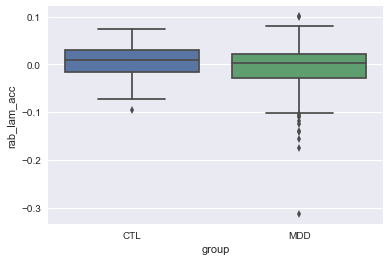

In [115]:
# Rab/Lam accuracy effect
sns.boxplot(flk_rl_use.rab_lam_acc,groupby=flk_rl_use.group,names=['Control','MDD'])

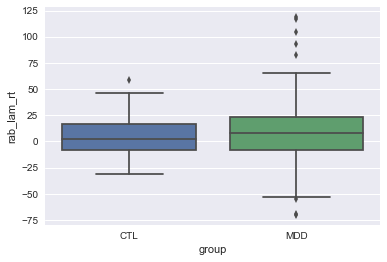

In [116]:
# Rab/Lam RT effect
sns.boxplot(flk_rl_use.rab_lam_rt,groupby=flk_rl_use.group,names=['Control','MDD'])

In [117]:
%Rpush flk_rl_use

In [118]:
# For Rab/Lam effect on accuracy, see if effect is greater than zero in each group, and then check group diff.
%R flk_rl_use.ctrl <- subset(flk_rl_use,group == 'CTL')
%R flk_rl_use.mdd <- subset(flk_rl_use,group == 'MDD')
%R print(t.test(flk_rl_use.ctrl$rab_lam_acc,mu=0)) # Controls, p = .38
%R print(t.test(flk_rl_use.mdd$rab_lam_acc,mu=0)) # MDD, p = .11
%R print(t.test(rab_lam_acc ~ group,flk_rl_use)) # No group difference, p = 0.15


	One Sample t-test

data:  flk_rl_use.ctrl$rab_lam_acc
t = 0.88374, df = 33, p-value = 0.3832
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.007722999  0.019584833
sample estimates:
  mean of x 
0.005930917 




	One Sample t-test

data:  flk_rl_use.mdd$rab_lam_acc
t = -1.5877, df = 246, p-value = 0.1136
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.011052353  0.001186524
sample estimates:
   mean of x 
-0.004932915 




	Welch Two Sample t-test

data:  rab_lam_acc by group
t = 1.469, df = 48.362, p-value = 0.1483
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.004002741  0.025730405
sample estimates:
mean in group CTL mean in group MDD 
      0.005930917      -0.004932915 



In [119]:
# For Rab/Lam effect on RT, see if effect is greater than zero in each group, and then check group diff.
%R print(t.test(flk_rl_use.ctrl$rab_lam_rt,mu=0)) # Controls, p = .14
%R print(t.test(flk_rl_use.mdd$rab_lam_rt,mu=0)) # MDD, p < .001 (evidence of post-error slowing)
%R print(t.test(rab_lam_rt ~ group,flk_rl_use)) # No group difference, p = 0.33


	One Sample t-test

data:  flk_rl_use.ctrl$rab_lam_rt
t = 1.5208, df = 33, p-value = 0.1378
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -1.917347 13.270416
sample estimates:
mean of x 
 5.676535 




	One Sample t-test

data:  flk_rl_use.mdd$rab_lam_rt
t = 5.5904, df = 246, p-value = 6.006e-08
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
  6.320765 13.197698
sample estimates:
mean of x 
 9.759232 




	Welch Two Sample t-test

data:  rab_lam_rt by group
t = -0.9908, df = 48.704, p-value = 0.3267
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -12.36461   4.19922
sample estimates:
mean in group CTL mean in group MDD 
         5.676535          9.759232 



In [120]:
# Get trial-level data for subjects who pass the flanker qc check
flk_ddm_use = flk_ddm_clin_s1[~flk_ddm_clin_s1.ProjectSpecificID.isin(flk_qc_fails)]

In [121]:
len(flk_ddm_use)

105350

In [122]:
# Confirming we have trial-level data from 35 controls and 266 depressed (with flanker_qc == 1)
bygroup = flk_ddm_use.groupby('group')
bygroup.ProjectSpecificID.nunique()

group
CTL     35
MDD    266
Name: ProjectSpecificID, dtype: int64

In [123]:
# For any trial-level analysis of Gratton or Rab/Lam, no need to worry about outliers or no-response trials b/c
# Flanker_proc.clean() handles them. But you do need to exclude those trials for the flanker interferene analyses.
# So let's create a df with no outliers and no no-response trials
flk_ddm_use_clean = flk_ddm_use[~(flk_ddm_use.outlier == 1.0) & ~(pd.isnull(flk_ddm_use.rt))]

In [124]:
len(flk_ddm_use_clean)

103801

In [125]:
# Give me mean accuracy by Stimulus for each group
by_grp_stim = flk_ddm_use_clean.groupby(['group','stimulus'])
by_grp_stim['accuracy'].mean()

group  stimulus
CTL    CON         0.987780
       INC         0.772006
MDD    CON         0.984785
       INC         0.791639
Name: accuracy, dtype: float64

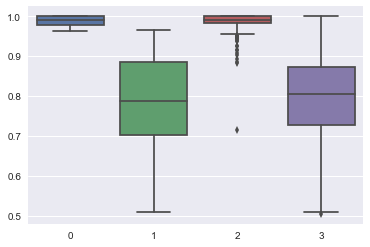

In [146]:

## Now boxplots of Group x Stimulus for accuracy . . . 

ctrl_con_acc = []
ctrl_inc_acc = []
mdd_con_acc = []
mdd_inc_acc = []

flk_acc_grpd = flk_ddm_use_clean.groupby(['group','stimulus','ProjectSpecificID'])['accuracy'].mean()

for key in flk_acc_grpd.keys():
    if key[0] == 'CTL' and key[1] == 'CON':
        ctrl_con_acc.append(flk_acc_grpd[key])
    elif key[0] == 'CTL' and key[1] == 'INC':
        ctrl_inc_acc.append(flk_acc_grpd[key])
    elif key[0] == 'MDD' and key[1] == 'CON':
        mdd_con_acc.append(flk_acc_grpd[key])
    elif key[0] == 'MDD' and key[1] == 'INC':
        mdd_inc_acc.append(flk_acc_grpd[key])

flk_acc_4plot = [ctrl_con_acc,ctrl_inc_acc,mdd_con_acc,mdd_inc_acc]
#ctrl_con_acc
sns.boxplot(data = flk_acc_4plot,names=['Ctrl:CON','Ctrl:INC','MDD:CON','MDD:INC'])

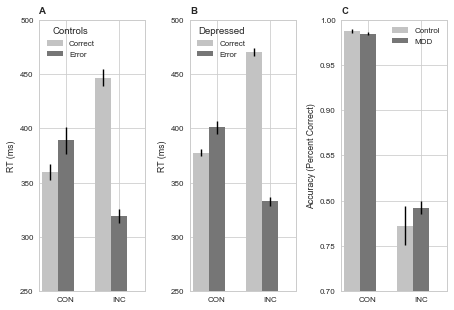

In [154]:
## Now boxplots of Group x Stimulus for accuracy. Initially very excited about factorplot (below), but having trouble
# getting it to plot a couple of things. More importantly, the SEM bars it generates are almost certainly not taking
# into account the number of subjects in each condition, but are instead working with N data points. That would 
# mislead most readers. Developed a better solution here--saved as Figure 2 for Psychological Medicine.

sns.set_style('whitegrid')
sns.set_context('paper')

## Plotting accuracy (Group x Stimulus)

ctrl_con_acc = []
ctrl_inc_acc = []
mdd_con_acc = []
mdd_inc_acc = []

flk_acc_means = flk_ddm_use_clean.groupby(['group','stimulus','ProjectSpecificID'])['accuracy'].mean()

for key in flk_acc_means.keys():
    if key[0] == 'CTL' and key[1] == 'CON':
        ctrl_con_acc.append(flk_acc_means[key])
            
    elif key[0] == 'CTL' and key[1] == 'INC':
        ctrl_inc_acc.append(flk_acc_means[key])
            
    elif key[0] == 'MDD' and key[1] == 'CON':
        mdd_con_acc.append(flk_acc_means[key])
            
    elif key[0] == 'MDD' and key[1] == 'INC':
        mdd_inc_acc.append(flk_acc_means[key])
        
ctrl_con_acc_se = sp.stats.sem(ctrl_con_acc)
ctrl_inc_acc_se = sp.stats.sem(ctrl_inc_acc)
mdd_con_acc_se = sp.stats.sem(mdd_con_acc)
mdd_inc_acc_se = sp.stats.sem(mdd_inc_acc)

ctrl_acc_means = [np.mean(ctrl_con_acc), np.mean(ctrl_inc_acc)]
ctrl_acc_se = [ctrl_con_acc_se, ctrl_inc_acc_se]

mdd_acc_means = [np.mean(mdd_con_acc),np.mean(mdd_inc_acc)]
mdd_acc_se = [mdd_con_acc_se, mdd_inc_acc_se]

# Plot accuracy
index = [0.1,0.6]
index = np.asarray(index)
width = 0.15

fig = plt.figure()
ax1 = fig.add_subplot(133)
ax1.set_ylim([0.7,1.0])
ax1.set_xlim([0,1])
ctrl_acc_bars = ax1.bar(index,ctrl_acc_means,width,yerr=ctrl_acc_se,color='#C3C3C3',ecolor='black',label='Control')
mdd_acc_bars = ax1.bar(index+width,mdd_acc_means,width,yerr=mdd_acc_se,color='#767676',ecolor='black',label='MDD')
ax1.set_xticks([0.25,0.75])
ax1.set_xticklabels(['CON','INC'])
ax1.set_ylabel('Accuracy (Percent Correct)')
#ax1.text(-0.3,1.01,'A',fontweight='bold') # I like the flexibility of text vs. set_title, but cannot get it to plot ax2
ax1.set_title('C',loc='left',fontweight='bold')
acc_legend = ax1.legend(loc='upper right')

## Plotting RT (Stimulus x Accuracy): Controls

ctrl_con0_rt = []
ctrl_con1_rt = []
ctrl_inc0_rt = []
ctrl_inc1_rt = []

flk_rt_means = flk_ddm_use_clean.groupby(['group','stimulus','accuracy','ProjectSpecificID'])['rt'].mean()

for key in flk_rt_means.keys():
    if key[0] == 'CTL' and key[1] == 'CON' and key[2] == 0.0:
        ctrl_con0_rt.append(flk_rt_means[key])
            
    elif key[0] == 'CTL' and key[1] == 'CON' and key[2] == 1.0:
        ctrl_con1_rt.append(flk_rt_means[key])
            
    elif key[0] == 'CTL' and key[1] == 'INC' and key[2] == 0.0:
        ctrl_inc0_rt.append(flk_rt_means[key])
            
    elif key[0] == 'CTL' and key[1] == 'INC' and key[2] == 1.0:
        ctrl_inc1_rt.append(flk_rt_means[key])
        
ctrl_con0_rt_se = sp.stats.sem(ctrl_con0_rt)
ctrl_con1_rt_se = sp.stats.sem(ctrl_con1_rt)
ctrl_inc0_rt_se = sp.stats.sem(ctrl_inc0_rt)
ctrl_inc1_rt_se = sp.stats.sem(ctrl_inc1_rt)

ctrl_corr_rt_means = [np.mean(ctrl_con1_rt), np.mean(ctrl_inc1_rt)]
ctrl_corr_rt_se = [ctrl_con1_rt_se, ctrl_inc1_rt_se]

ctrl_err_rt_means = [np.mean(ctrl_con0_rt), np.mean(ctrl_inc0_rt)]
ctrl_err_rt_se = [ctrl_con0_rt_se, ctrl_inc0_rt_se]

# Now plot RT for the controls
ax2 = fig.add_subplot(131)
ax2.set_ylim([250,500])
ax2.set_xlim([0,1])
ctrl_corr_rt_bars = ax2.bar(index,ctrl_corr_rt_means,width,yerr=ctrl_corr_rt_se,
                           color='#C3C3C3',ecolor='black',label='Correct')
ctrl_err_rt_bars = ax2.bar(index+width,ctrl_err_rt_means,width,yerr=ctrl_err_rt_se,
                          color='#767676',ecolor='black',label='Error')
ax2.set_xticks([0.25,0.75])
ax2.set_xticklabels(['CON','INC'])
ax2.set_ylabel('RT (ms)')
ax2.set_title('A',loc='left',fontweight='bold')
acc_legend = ax2.legend(loc='upper left', title='Controls')

## Plotting RT (Stimulus x Accuracy): MDD

mdd_con0_rt = []
mdd_con1_rt = []
mdd_inc0_rt = []
mdd_inc1_rt = []

for key in flk_rt_means.keys():
    if key[0] == 'MDD' and key[1] == 'CON' and key[2] == 0.0:
        mdd_con0_rt.append(flk_rt_means[key])
            
    elif key[0] == 'MDD' and key[1] == 'CON' and key[2] == 1.0:
        mdd_con1_rt.append(flk_rt_means[key])
            
    elif key[0] == 'MDD' and key[1] == 'INC' and key[2] == 0.0:
        mdd_inc0_rt.append(flk_rt_means[key])
            
    elif key[0] == 'MDD' and key[1] == 'INC' and key[2] == 1.0:
        mdd_inc1_rt.append(flk_rt_means[key])
        
mdd_con0_rt_se = sp.stats.sem(mdd_con0_rt)
mdd_con1_rt_se = sp.stats.sem(mdd_con1_rt)
mdd_inc0_rt_se = sp.stats.sem(mdd_inc0_rt)
mdd_inc1_rt_se = sp.stats.sem(mdd_inc1_rt)

mdd_corr_rt_means = [np.mean(mdd_con1_rt), np.mean(mdd_inc1_rt)]
mdd_corr_rt_se = [mdd_con1_rt_se, mdd_inc1_rt_se]

mdd_err_rt_means = [np.mean(mdd_con0_rt), np.mean(mdd_inc0_rt)]
mdd_err_rt_se = [mdd_con0_rt_se, mdd_inc0_rt_se]

# Now plot RT for the MDD group
ax3 = fig.add_subplot(132)
ax3.set_ylim([250,500])
ax3.set_xlim([0,1])
mdd_corr_rt_bars = ax3.bar(index,mdd_corr_rt_means,width,yerr=mdd_corr_rt_se,
                           color='#C3C3C3',ecolor='black',label='Correct')
mdd_err_rt_bars = ax3.bar(index+width,mdd_err_rt_means,width,yerr=mdd_err_rt_se,
                          color='#767676',ecolor='black',label='Error')
ax3.set_xticks([0.25,0.75])
ax3.set_xticklabels(['CON','INC'])
ax3.set_ylabel('RT (ms)')
ax3.set_title('B',loc='left',fontweight='bold')
acc_legend = ax3.legend(loc='upper left', title='Depressed')

## Space the subplots correctly, show, and save
plt.tight_layout()
#plt.savefig('/Users/danieldillon/Work/Expts/EMBARC/Manuscripts/Flanker/Figures/Fig2.eps',format='eps',transparent=True)
plt.show()

In [159]:
# Correlation b/w CON and INC accuracy in each group
ctrl_acc_correl = pearsonr(ctrl_con_acc,ctrl_inc_acc)
mdd_acc_correl = pearsonr(mdd_con_acc,mdd_inc_acc)

print ('Ctrls: CON and INC acc, r = ' + '{:.2f}'.format(ctrl_acc_correl[0]) + ', p = ' + '{:.2f}'.format(ctrl_acc_correl[1]))
print ('MDD: CON and INC acc, r = ' + '{:.2f}'.format(mdd_acc_correl[0]) + ', p = ' + '{:.2f}'.format(mdd_acc_correl[1]))

Ctrls: CON and INC acc, r = 0.25, p = 0.15
MDD: CON and INC acc, r = 0.26, p = 0.00


In [160]:
# Using the trial-level data, let's run a linear mixed-model in which we predict accuracy with Site and Group*Stimulus
# Group*Stimulus would ideally show that INC trials are especially tough for MDD subjects; based on the boxplots, 
# seems more likely to show that MDDs are worse than controls on CON trials (and maybe better on INC trials).
# I have ProjectSpecificID as a random effect: each subject gets his or her own intercept
# The two stimulus conditions--CON and INC--are exhaustive, so Stimulus is a fixed effect
# The two groups are exhaustive for this study, so Group is a fixed effect
# The four sites are exhaustive for this study, so Site is a fixed effect. I could imagine it being random b/c these
# four sites are not exhaustive in the same way that the two groups and stimuli are, but I think this approach is ok.
# Our hypothesis is that Group and Stimulus interact, but Site is not expected to and would be uninterpretable.
# So no interaction with Site is specified.
# Returns an effect of Stimulus (INC < CON) and Group x Stimulus, due to MDD > Ctrl for INC (but reverse for CON)

%Rpush flk_ddm_use_clean
%R library(lmerTest)
%R flk_ddm_use_clean$group <- as.factor(flk_ddm_use_clean$group)
%R flk_ddm_use_clean$site <- as.factor(flk_ddm_use_clean$site)
%R flk_ddm_use_clean$stimulus <- as.factor(flk_ddm_use_clean$stimulus)

# Create the model
%R flk_ddm_use_clean.acc1 = lmer(accuracy ~ site + group*stimulus + (1|ProjectSpecificID), data=flk_ddm_use_clean)

# Print the results:
%R print(summary(flk_ddm_use_clean.acc1))


Error in library(lmerTest) : there is no package called ‘lmerTest’

Error in is.factor(x) : object 'flk_ddm_use_cleanUM' not found


Linear mixed model fit by REML ['lmerMod']
Formula: accuracy ~ site + group * stimulus + (1 | ProjectSpecificID)
   Data: flk_ddm_use_clean

REML criterion at convergence: 11162.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1506 -0.0572  0.0793  0.5990  1.6831 

Random effects:
 Groups            Name        Variance Std.Dev.
 ProjectSpecificID (Intercept) 0.002044 0.04521 
 Residual                      0.064697 0.25436 
Number of obs: 103801, groups:  ProjectSpecificID, 301

Fixed effects:
                      Estimate Std. Error t value
(Intercept)           0.980923   0.009408  104.27
siteMG                0.001598   0.008175    0.20
siteTX                0.011884   0.006935    1.71
siteUM                0.012846   0.007878    1.63
groupMDD             -0.002933   0.008739   -0.34
stimulusINC          -0.215573   0.004869  -44.27
groupMDD:stimulusINC  0.022589   0.005181    4.36

Correlation of Fixed Effects:
            (Intr) siteMG siteTX siteUM grpMDD stmIN